__Import Libraries__

In [1]:
import time
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

__Load Data__

In [2]:
digits = pd.read_csv('digits.csv')
digits.sample(3)

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
14094      4       0       0       0       0       0       0       0       0   
36003      0       0       0       0       0       0       0       0       0   
19408      5       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
14094       0  ...         0         0         0         0         0   
36003       0  ...         0         0         0         0         0   
19408       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
14094         0         0         0         0         0  
36003         0         0         0         0         0  
19408         0         0         0         0         0  

[3 rows x 785 columns]

In [3]:
digits.iloc[:,1:].shape

(42000, 784)

__Visualize__

Label :  1 
Image : 


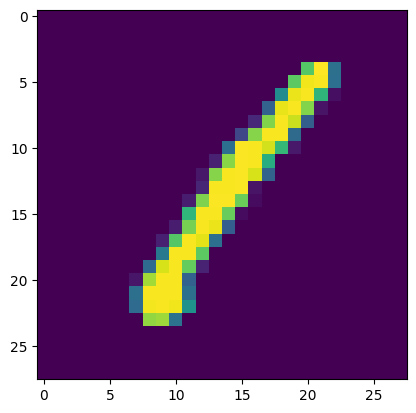

In [4]:
print("Label : ", digits.label[0], "\nImage : ")
plt.imshow(digits.iloc[0,1:].values.reshape(28,28))

__Split Data__

In [5]:
X = digits.iloc[:,1:]
y = digits.label

print(X.shape, y.shape)

(42000, 784) (42000,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=digits.label)
print(X_train.shape, X_test.shape)

(33600, 784) (8400, 784)


__Use KNN for Classification__

In [7]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [8]:
s = time.time()
y_pred = knn.predict(X_test)

print("Time taken to predict : ", time.time() - s)

Time taken to predict :  21.916401147842407


In [9]:
accuracy_score(y_test, y_pred)

0.9645238095238096

~96% Accuracy achieved. 

Now Let's use PCA to transform this higher Dimensional data into smaller Dimensional data and check if that affects the accuracy.

__Scale Data__

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

__Implement PCA__

In [11]:
# Default: pca = PCA(n_components=None) -> Same number of components as provided. (Here, 784)

# Try with 100
pca = PCA(n_components=100)
X_train_trf = pca.fit_transform(X_train_scaled)
X_test_trf = pca.transform(X_test_scaled)

In [12]:
X_train_trf.shape

(33600, 100)

In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train_trf, y_train)

KNeighborsClassifier()

In [14]:
s2 = time.time()
y_pred2 = knn.predict(X_test_trf)

print("Time taken to predict 100D data: ", time.time() - s2)

Time taken to predict 100D data:  1.753422498703003


In [15]:
accuracy_score(y_test, y_pred2)

0.9511904761904761

~95% Accuracy when only top 100 features are considered.

But, `how do we know its 100 PCs and not lesser or greater?` 

In other words, `how to choose the most optimal number of features for classification ?`

Before answering this question, firstly, we will visualze this data in 2D and 3D.

In [16]:
def visualize(data, dims=2, y=y_train.astype(str)):

    pca = PCA(n_components=dims)
    X = pca.fit_transform(data)

    if dims==2:
        fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y, color_discrete_sequence=px.colors.qualitative.G10)
        fig.show()

    elif dims==3:
        fig = px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:,2] ,color=y)
        fig.update_layout(margin=dict(l=20, r=20, b=20, t=20))
        fig.show()

    return pca.explained_variance_, pca.components_, pca.explained_variance_ratio_

eigen_values, eigen_vectors, eigen_values_contr = visualize(X_train_trf)

In [17]:
eigen_values, eigen_vectors, eigen_values_contr = visualize(X_train_trf, 3)

__Eigen Decomposition__

In [18]:
# Eigen Value : pca.explained_variance_
eigen_values

array([40.78124535, 29.13817348, 26.76652551])

In [19]:
# Eigenvectors : pca.components_
eigen_vectors.shape

(3, 100)

__Find Optimum number of Principle Components__

For optimum number of components, all vectors should contribute some percentage to a cumulative variance of >= 90% of actual data.

i.e. 
$$ for~784~~~=>~~ \lambda _1 + \lambda _2 + \lambda _3 + ... +  \lambda _7~_8~_4 $$

$Where~contribution~of~each~eigen~vector~:$ 
$$ \frac{\lambda _1} {\lambda _1  + \lambda _2 + \lambda _3 + ... +  \lambda _7~_8~_4} * 100$$

in `sklearn` it is given by 
```python
from sklearn.decomposition import PCA
pca = PCA()
# Code here..
pca.explained_variance_ratio_
```

In [20]:
# Contribution of each eigen vector:
print(*[f"\nVector {i+1} : " + str(round(v*100, 2)) + '%' for i,v in enumerate(eigen_values_contr)])


Vector 1 : 8.1% 
Vector 2 : 5.78% 
Vector 3 : 5.31%


Continuing above logic we can create 784 PCs and find the cumulative sum of each PC until it reaches to >=90.

In [21]:
pca = PCA(n_components=None)
X_train_trf = pca.fit_transform(X_train_scaled)
X_test_trf = pca.transform(X_test_scaled)

In [22]:
pca_EVR = pca.explained_variance_ratio_

In [23]:
pca_EVR.shape

(784,)

In [24]:
# First 10 vectors of these 784 vectors:
pca_EVR[:10]

array([0.05809121, 0.04150613, 0.03812782, 0.02968701, 0.02583442,
       0.02245172, 0.01983923, 0.01791781, 0.01573707, 0.01440992])

In [25]:
# Cumulative sum of these vectors:
cumsumEVR = np.cumsum(pca_EVR)
cumsumEVR[:10]

array([0.05809121, 0.09959735, 0.13772517, 0.16741218, 0.1932466 ,
       0.21569832, 0.23553754, 0.25345535, 0.26919242, 0.28360234])

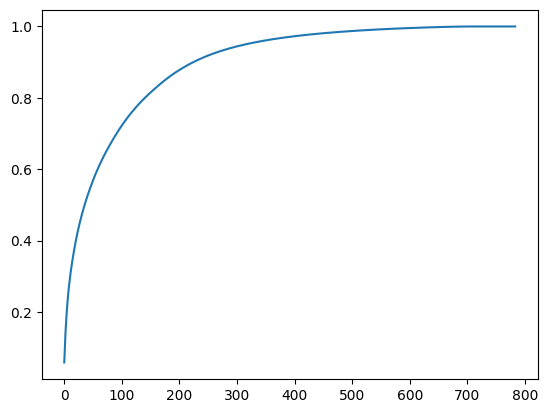

In [26]:
plt.plot(cumsumEVR)

By this plot we can see that the sum increases till the 250-300 PCs but after that it tends to 1.

In [27]:
# We can also use a function to find the same:
def optimum_PC(evr=cumsumEVR, threshold=90):
    x = 0
    for i in evr:
        x+=1
        if i*100 > threshold:
            return x

optimum_PC()

226

Finally,

In [28]:
pca = PCA(n_components=optimum_PC())
X_train_trf = pca.fit_transform(X_train_scaled)
X_test_trf = pca.transform(X_test_scaled)

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_train_trf, y_train)

KNeighborsClassifier()

In [30]:
s3 = time.time()
y_pred = knn.predict(X_test_trf)

print("Time for prediction after optimization: ", time.time() - s3)

Time for prediction after optimization:  3.3722245693206787


In [31]:
accuracy_score(y_test, y_pred)

0.945